In [1]:
# importing necessary libraries and start a spark session
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.246:7077") \
        .appName("mental_health_analysis")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",2)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext

# just show errors
spark_context.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/10 09:02:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# read the dataset from hdfs
data = spark_session.read.json("hdfs://192.168.2.142:9000/user/ubuntu/data/corpus-webis-tldr-17.json")
# print schema
# data.printSchema()

In [3]:
# show the first 10 rows
# data.show(10)

In [4]:
# convert spark dataframe to Pandas dataframe to show the dataset in a better format
# data_pandas = data.limit(10).toPandas()
# display(data_pandas)

In [3]:
# drop unnecessary columns
subset_data = data.drop('author', 'body','normalizedBody', 'summary', 'subreddit_id', 'title', 'summary_len','content_len')
# subset_data.count()

3848330

In [6]:
# print total number of rows
# print("The number of total rows of the dataset is: \t", data.count())
# print the number of different subreddits
# print("The number of different subreddits is: \t", data.select("subreddit").distinct().count())

In [7]:
# take a subset of the data
# subset_data = data.orderBy('id').limit(100000)
# subset_data.show(10)

In [4]:
# defining some general keywords related to mental health
keywords = [
    'anxiety', 'panic attack', 'phobia', 
    'depression', 'bipolar', 'cyclothymia',
    'schizophrenia', 'anorexia', 'bulimia', 'binge eating', 
    'addiction', 'obsessive compulsive disorder', 'ocd', 'borderline', 
    'antisocial','ptsd', 'trauma', 'post-traumatic stress disorder',
    'amnesia', 'stress', 'eating disorder',
    'suicide', 'suicidal', 'self-harm'
]

In [5]:
# broadcast of keywords
broadcasted_keywords = spark_session.sparkContext.broadcast(keywords)

#### Counting subreddits that are equal to each keyword

In [6]:
# preprocess subreddit column
subset_data = subset_data.withColumn('subreddit', lower(trim(col('subreddit'))))

# create a dataframe from the list of keywords
keywords_data = spark_session.createDataFrame([(k,) for k in broadcasted_keywords.value], ['keyword'])

# count the occurrences of each subreddit that is equal to keyword
# joining subset_data with keywords_data where subeddit = keyword
# group the join result by keyword column
# count the number of each keyword
# sort the count in descending order
keyword_counts_data = (
    subset_data
    .join(keywords_data, col('subreddit') == col('keyword'), 'right_outer')
    .groupBy('keyword')
    .count()
    .orderBy('count', ascending=False)
)

keyword_counts_data.show()

+---------------+-----+
|        keyword|count|
+---------------+-----+
|     depression|11365|
|        anxiety| 4126|
|        bipolar| 1646|
|            ocd|  356|
|           ptsd|  271|
|  schizophrenia|  204|
|      addiction|  179|
|         stress|   13|
|        amnesia|   11|
|         phobia|   10|
|        bulimia|    3|
|         trauma|    2|
|   binge eating|    1|
|       suicidal|    1|
|    cyclothymia|    1|
|       anorexia|    1|
|eating disorder|    1|
|     antisocial|    1|
|   panic attack|    1|
|     borderline|    1|
+---------------+-----+
only showing top 20 rows



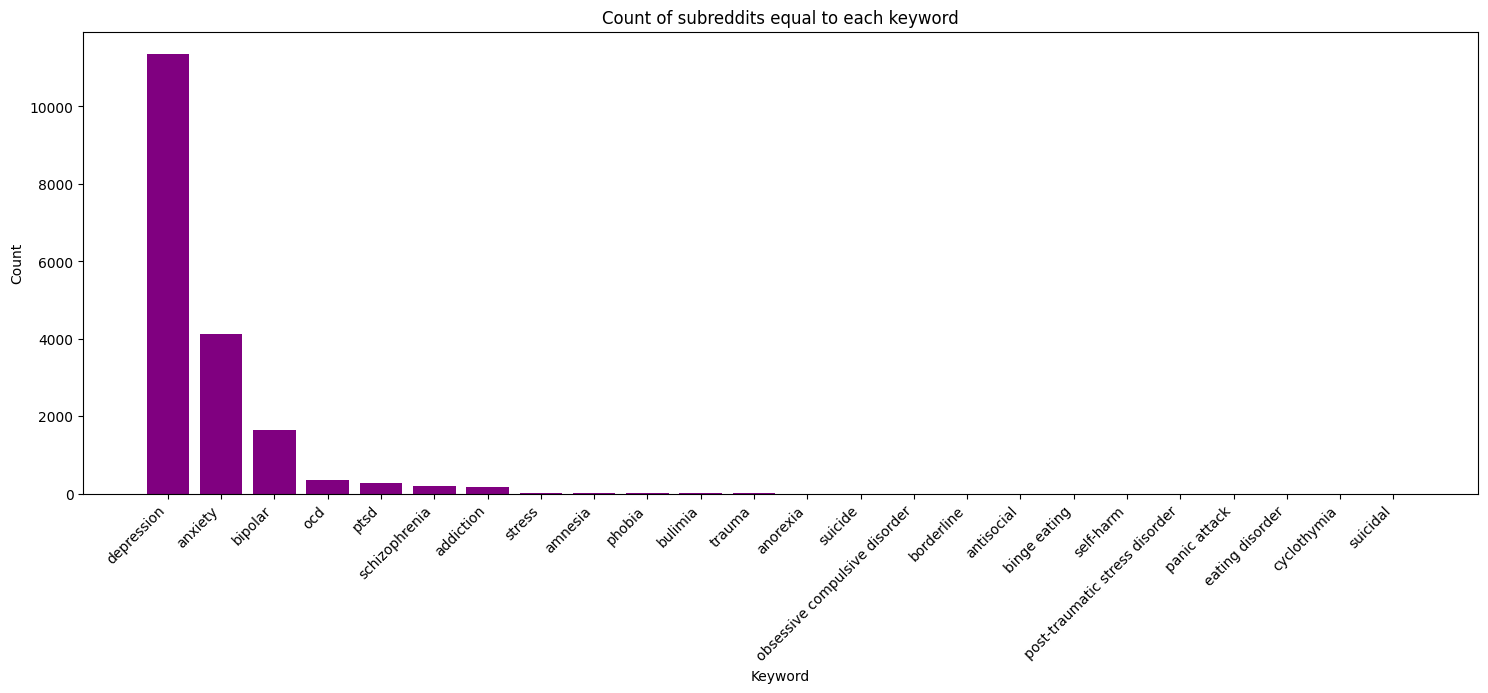

In [7]:
# convert PySpark dataframe to pandas dataframe
keyword_counts_pandas = keyword_counts_data.toPandas()

# sort
keyword_counts_pandas = keyword_counts_pandas.sort_values(by='count', ascending=False)

plt.figure(figsize=(18, 6))
plt.bar(keyword_counts_pandas['keyword'], keyword_counts_pandas['count'], color='purple')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Count of subreddits equal to each keyword')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Counting how many times each keyword was included in a content of a subreddit at least once in total

In [8]:
# UDF to filter content based on keywords
def filter_keywords(content, keywords):
    return [keyword for keyword in keywords if keyword in content]

filter_keywords_udf = udf(lambda content: filter_keywords(content, broadcasted_keywords.value), ArrayType(StringType()))

# create the hasKeyword column
subset_data = subset_data.withColumn("keywordsList", filter_keywords_udf(col('content')))

# explode the hasKeyword array into a new row for each keyword present per content
subset_data = subset_data.withColumn("keyword", explode("keywordsList"))

# save rows where its content include keyword
related_data = subset_data.filter(size("keywordsList") > 0)

# count the occurrences of each keyword
content_counts_data = subset_data.groupBy('keyword')
content_counts_data.show(truncate=False)

+---------------+------+
|keyword        |count |
+---------------+------+
|bulimia        |885   |
|anorexia       |1672  |
|suicide        |32304 |
|trauma         |18322 |
|antisocial     |2050  |
|stress         |119606|
|borderline     |9076  |
|phobia         |6651  |
|suicidal       |16493 |
|addiction      |20105 |
|ocd            |438   |
|depression     |79817 |
|amnesia        |919   |
|eating disorder|4278  |
|panic attack   |14137 |
|bipolar        |9579  |
|ptsd           |571   |
|self-harm      |2293  |
|binge eating   |720   |
|anxiety        |71156 |
+---------------+------+
only showing top 20 rows



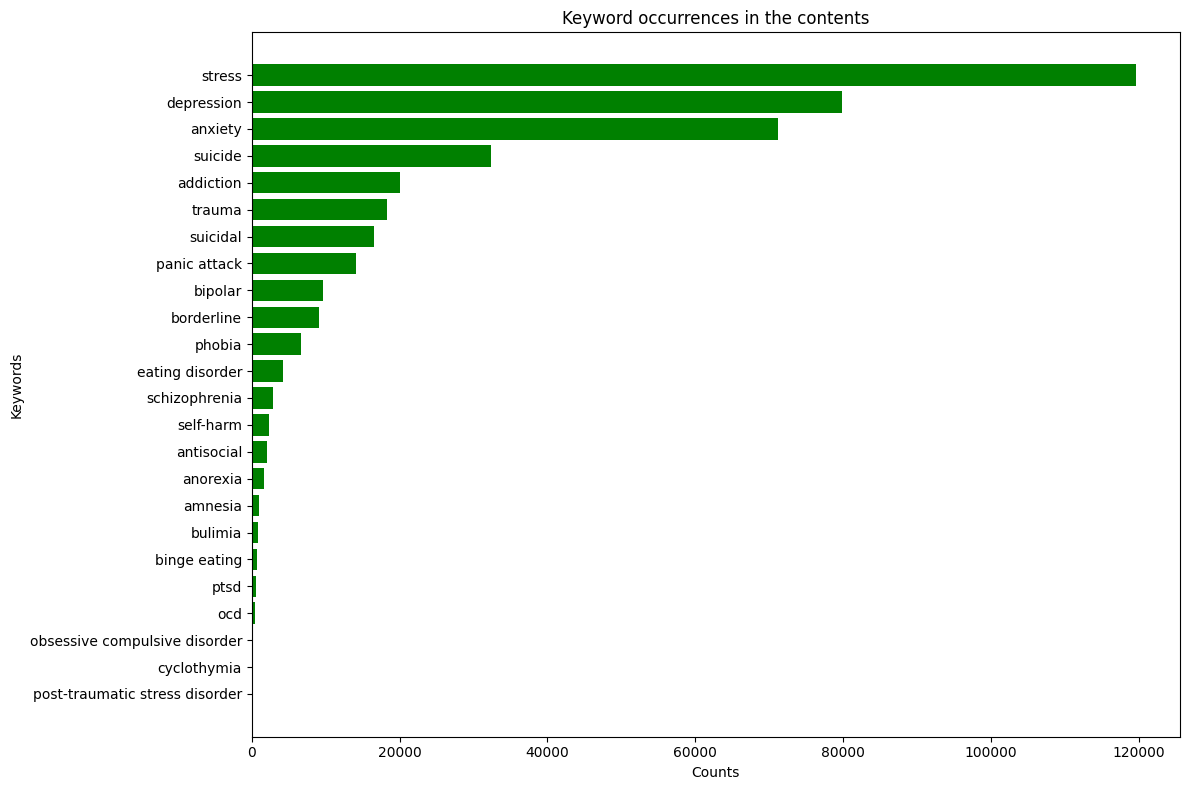

In [9]:
# sort by count in descending order
content_counts_data = content_counts_data.orderBy(col('count').asc())
content_counts_pandas = content_counts_data.toPandas()

plt.figure(figsize=(12, 8))
plt.barh(content_counts_pandas['keyword'], content_counts_pandas['count'], color='green')
plt.xlabel('Counts')
plt.ylabel('Keywords')
plt.title('Keyword occurrences in the contents')
plt.tight_layout()
plt.show()

#### counting how many of mental health related content include LGBTQ related words

In [10]:
# define LGBTQ keywords
lgbtq_keywords = [
    'lgbtq', 'lgbt', 'lgbtq+', 'queer', 'gay', 'lesbian', 'bisexual', 'transgender',
    'trans', 'nonbinary', 'genderqueer', 'genderfluid', 'intersex', 'asexual',
    'pansexual',
]

In [11]:
# broadcast keywords
from pyspark.sql.functions import explode
# broadcast lgbtq keywords
lgbtq_keywords_bc = spark_session.sparkContext.broadcast(lgbtq_keywords)

# to find lgbtq words in content column
def find_lgbtq_keywords(content):
    content_lower = content.lower()
    return [keyword for keyword in lgbtq_keywords_bc.value if keyword in content_lower]

# define UDF
find_lgbtq_keywords_udf = udf(find_lgbtq_keywords, ArrayType(StringType()))

# apply UDF on content column
related_data = related_data.withColumn("LGBTQ_list", find_lgbtq_keywords_udf(col('content')))

# explode the LGBTQ_list column
related_data_exploded = related_data.withColumn("LGBTQ_keyword", explode(col("LGBTQ_list")))

# sum counts
LGBTQ_counts = related_data_exploded.groupBy("LGBTQ_keyword").count().orderBy(col("count").desc())

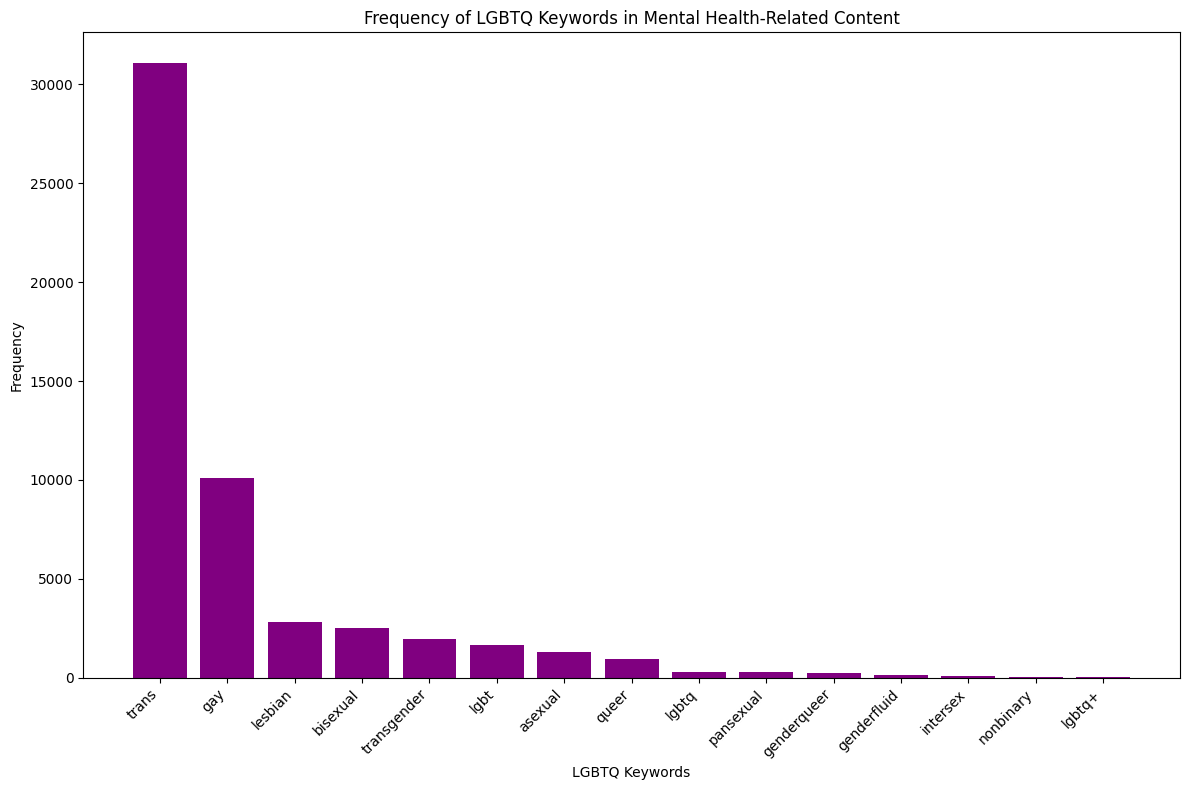

In [12]:
# convert to pandas
LGBTQ_counts_pandas = LGBTQ_counts.toPandas()

plt.figure(figsize=(12, 8))
plt.bar(LGBTQ_counts_pandas['LGBTQ_keyword'], LGBTQ_counts_pandas['count'], color='purple')
plt.xlabel('LGBTQ Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of LGBTQ Keywords in Mental Health-Related Content')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [13]:
# # broadcast the LGBTQ keywords
# lgbtq_keywords_broadcast = spark_session.sparkContext.broadcast(lgbtq_keywords)
# def find_lgbtq_keywords(content, keywords):
#     content_lower = content.lower()
#     return [keyword for keyword in keywords.value if keyword in content_lower]

# # UDF for finding LGBTQ keywords
# find_lgbtq_keywords_udf = udf(lambda content: find_lgbtq_keywords(content, lgbtq_keywords_broadcast), ArrayType(StringType()))

# # apply udf on content column
# related_data = related_data.withColumn("lgbtqKeywords", find_lgbtq_keywords_udf(col('content')))

# # filter rows that have LGBTQ keyword
# lgbtq_related = related_data.filter(size(col("lgbtqKeywords")) > 0)

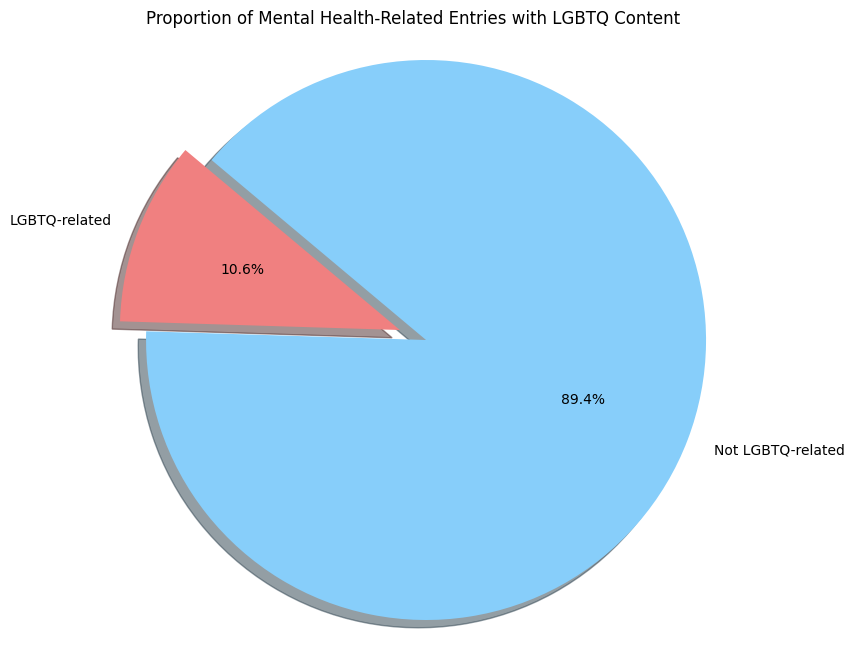

In [14]:
# # count the number of LGBTQ related rows and the total mental health related
# lgbtq_count = lgbtq_related.count()
# total_mental_health_related = related_data.count()

# lgbtq_proportion = lgbtq_count / total_mental_health_related if total_mental_health_related else 0

# #plot pie chart
# labels = ['LGBTQ-related', 'Not LGBTQ-related']
# sizes = [lgbtq_proportion, 1 - lgbtq_proportion]
# colors = ['lightcoral', 'lightskyblue']
# explode = (0.1, 0) 

# plt.figure(figsize=(8, 8))
# plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
# plt.title('Proportion of Mental Health-Related Entries with LGBTQ Content')
# plt.axis('equal')
# plt.show()